# Analyze Live Events with IBM Db2 Event Store

This notebook demonstrates how to interact with IBM Db2 Event Store.

An external program will insert data about taxi trip duration while this notebook continuously charts updated statistics.


## 1.  Connect to IBM Db2 Event Store

### 1.1 Determine the IP address of your host

Obtain the IP address of the host that you want to connect to by running the appropriate command for your operating system:

* On Mac, run: `ifconfig`
* On Windows, run: `ipconfig`
* On Linux, run: `hostname -i`

On most systems, running this Python command will print the correct IP address:

```
python -c "import socket; print(socket.gethostbyname(socket.gethostname()))"
```

Edit the `HOST = "XXX.XXX.XXX.XXX"` value in the next cell to provide the IP address.


In [1]:
# Set your host IP address
HOST = "192.168.0.105"

# Port will be 1100 for version 1.1.2 or later (5555 for version 1.1.1)
PORT = "1100"

# Set your Event user/pass below and for the data loader program
EVENT_USER = "admin"
EVENT_PASSWORD = "password"

# Port that the external program will use for communication
DAEMON_PORT = 9292

### 1.2 Establishing a connection 

To establish a connection to IBM Db2 Event Store, you need connection endpoints. Use the configuration reader to provide a set of APIs for Event Store connection and configuration.<br/>

```
ConfigurationReader.setConnectionEndpoints("<HostName>:<PortNumber>")
```

You can also specify multiple connection endpoints by providing a connection string that contains a comma-separated list of HostName:PortNumber pairs.<br/>
```
ConfigurationReader.setConnectionEndpoints("<Host1>:<Port1>,<Host2>:<Port2>,<Host3>:<Port3>")
```

Using the configuration reader API, set up the endpoints and the user and password that will be used to connect to Event Store.

In [2]:
from eventstore.oltp import EventContext
from eventstore.oltp.row_generator import generate_tele
from eventstore.catalog import TableSchema, IndexSpecification, SortSpecification, ColumnOrder
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from eventstore.common import ConfigurationReader

spark = SparkSession.builder.getOrCreate()
ConfigurationReader.setConnectionEndpoints("%s:%s" % (HOST, PORT))
ConfigurationReader.setEventUser(EVENT_USER)
ConfigurationReader.setEventPassword(EVENT_PASSWORD)
spark.version

'2.1.0'

## 2. Define a database  
Only one database can be active in Db2 Event Store. If you already have a database, you don't need to create one.<br/>
To create a database in Event Store, you can use the `createDatabase` method 

In [3]:
EventContext.drop_database("TESTDB") # uncomment this line if you need to first drop the database
EventContext.create_database("TESTDB")

###  2.1 Open an existing database
To use an existing database, use the following call:

In [4]:
ctx = EventContext.get_event_context("TESTDB")

<a id="create-table"></a>
## 3. Create your table

### 3.1 Define a schema for the table
To create a new table, you must first specify a schema for the table.
Specify the columns, sharding key, and primary key, as required.<br/>
Note that currently String is not supported as a primary key or sharding key.<br/>
<i>The `timestamp` is not supported in the first release but still works.</i>

In [5]:
from eventstore.catalog import TableSchema
from pyspark.sql.types import *

schema = StructType([
        StructField("id", LongType(), nullable = False),
        StructField("taxiId", StringType(), nullable = True),
        StructField("tripId", StringType(), nullable = True),
        StructField("tripStartTime", TimestampType(), nullable = True),
        StructField("tripEndTime", TimestampType(), nullable = True),
        StructField("pickupLong", DoubleType(), nullable = True),
        StructField("pickupLat", DoubleType(), nullable = True),
        StructField("dropoffLong", DoubleType(), nullable = True),
        StructField("dropoffLat", DoubleType(), nullable = True),
        StructField("tripTotal", DoubleType(), nullable = True),
        StructField("tripMiles", DoubleType(), nullable = True),
        StructField("tripSeconds", DoubleType(), nullable = True)
])  
table_schema = TableSchema("TaxiTrips", schema,
                            sharding_columns=["id"],
                            pk_columns=["id"])

> <b>Tip:</b> Databases in Event Store are partitioned into shards. Any Event Store node of a multi-node Event Store cluster contains 0, 1 or N shards of the defined database. In addition to the mandatory shard key, there is also the option to provide a primary key. When this key is defined, Event Store ensures that only a single version of each primary key exists in the database. In the above example, a sharding key and a primary key are defined on column id. 

<a id="create-table-two"></a>
### 3.2 Create the table
Create the Event Store table based on the above, unresolved schema.

In [6]:
ctx.create_table(table_schema)
table_names = ctx.get_names_of_tables()
for idx, name in enumerate(table_names):
    print(name)

TaxiTrips


### 3.3 Start the insertion program
There is a deamon program running on the host that waits for a command to start the insertion.
<ul>
<li>IP address: ignored in this environment</li>
<li>rate      : records per second insertion rate</li>
<li>db name   : name of the database used</li>
<li>table name: name of the table</li>
</ul>

In [7]:
import socket               # Import socket module

s = socket.socket()         # Create a socket object

s.connect((HOST, DAEMON_PORT))
# <ip address>,<rate>,<db name>,<table name>
msg = "0.0.0.0,100,TESTDB,TaxiTrips\n"
s.send(msg.encode())
ret = s.recv(1024).decode()
s.close
print(ret)

Insert process started



## 4. Query the table 

<a id="connect-to-es-two"></a>
### 4.1 Connect to  Event Store 

When connecting Event Store for the first time, you need to provide connection endpoints using the configuration reader.<br/>
If you are in the same session that created the database and table, you don't need to execute this step.<br/>
If you are in a new session, make sure you executed step 1.

### 4.2 Create EventSession

To run a Spark SQL query, you need to establish an Event Store Spark session.

In [8]:
from eventstore.sql import EventSession

eventSession = EventSession(spark.sparkContext, "TESTDB")
eventSession.open_database()
eventSession.set_query_read_option("SnapshotNone")

### 4.3 Prepare a DataFrame for the query 
The following API provides a DataFrame that holds the query results on the Event Store table. 

In [9]:
reviewTab = eventSession.load_event_table("TaxiTrips")
reviewTab.createOrReplaceTempView("TaxiTrips")

### 4.4 Run SQL queries
Now you can materialize the dataframe associated with the sql query by using show().  Start with a simple `count(*)` query.

In [10]:
resultSet1 = eventSession.sql("SELECT count(*) as totalRows FROM TaxiTrips")
resultSet1.show()

+---------+
|totalRows|
+---------+
|      800|
+---------+



This query shows an aggregation. Since it is executed after the previous one you should see a larger number of total records. If you want to test for an empty dataset, use head(1).

In [11]:
resultSet2 = eventSession.sql("""
SELECT date_format(tripStartTime, 'HH:mm') as StartTime, count(*) as count, avg(tripTotal) as AvgTotal,
                      avg(tripMiles) as AvgMiles, 
                      avg(unix_timestamp(tripEndTime) - unix_timestamp(tripStartTime)) as AvgDuration
FROM TaxiTrips
GROUP BY date_format(tripStartTime, 'HH:mm')
ORDER BY 1
""")
if not resultSet2.head(1):
    print("Empty dataset. Is the event loader running?")
else:
    resultSet2.show()

+---------+-----+------------------+------------------+-----------------+
|StartTime|count|          AvgTotal|          AvgMiles|      AvgDuration|
+---------+-----+------------------+------------------+-----------------+
|    08:00|  573|10.870471204188485|2.5656719022687593|796.3350785340314|
|    08:15|  927|28.926860841423935|2.8435814455231885|549.5145631067961|
+---------+-----+------------------+------------------+-----------------+



Running in a loop with a little sleep() shows that the data in the latest time slice is changing.

In [12]:
import time
for i in range(0, 3):
    resultSet2 = eventSession.sql("""
SELECT date_format(tripStartTime, 'HH:mm') as StartTime, count(*) as count, avg(tripTotal) as AvgTotal,
                      avg(tripMiles) as AvgMiles, 
                      avg(unix_timestamp(tripEndTime) - unix_timestamp(tripStartTime)) AvgDuration
FROM TaxiTrips
GROUP BY date_format(tripStartTime, 'HH:mm')
ORDER BY 1
""")
    resultSet2.show()
    time.sleep(1);

+---------+-----+------------------+------------------+-----------------+
|StartTime|count|          AvgTotal|          AvgMiles|      AvgDuration|
+---------+-----+------------------+------------------+-----------------+
|    08:00|  573|10.870471204188485|2.5656719022687593|796.3350785340314|
|    08:15| 1027| 28.10222005842258|3.0688120740019427|549.4644595910419|
+---------+-----+------------------+------------------+-----------------+

+---------+-----+------------------+------------------+-----------------+
|StartTime|count|          AvgTotal|          AvgMiles|      AvgDuration|
+---------+-----+------------------+------------------+-----------------+
|    08:00|  573|10.870471204188485|2.5656719022687593|796.3350785340314|
|    08:15| 1368| 23.76663011695905| 3.043764619883037|548.6842105263158|
|    08:30|   59|10.089491525423728| 1.606101694915254|610.1694915254237|
+---------+-----+------------------+------------------+-----------------+

+---------+-----+------------------+

Watch the latest time slice in an animated matplotlib chart to see the record count and average trip duration update as events stream in.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

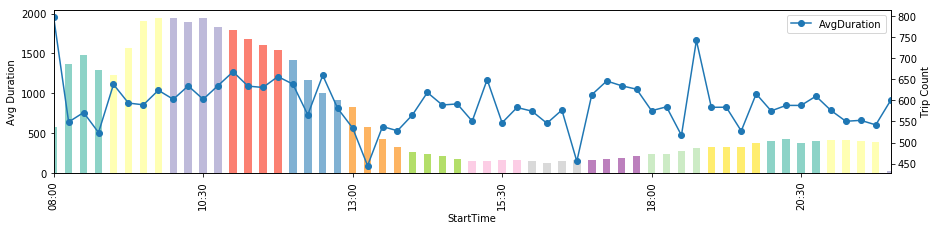

In [14]:
import matplotlib.cm as cm
import matplotlib.animation
from IPython.display import display, clear_output

colors = cm.Set3(np.linspace(0,1,48))
plt.rcParams["figure.figsize"] = (15, 3)

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_ylabel("Avg Duration")
ax.set_xlabel("Start Time")

def draw_chart(fig, ax, ax2):
    clear_output(wait=True)
    resultSet2 = eventSession.sql("""
SELECT date_format(tripStartTime, 'HH:mm') as StartTime, count(*) as count, avg(tripTotal) as AvgTotal,
                      avg(tripMiles) as AvgMiles,
                      avg(unix_timestamp(tripEndTime) - unix_timestamp(tripStartTime)) as AvgDuration
FROM TaxiTrips
GROUP BY date_format(tripStartTime, 'HH:mm')
ORDER BY 1
""")
    pdf = resultSet2.toPandas();
    pdf[['StartTime', 'count']].plot(x='StartTime', y='count', kind='bar', color=colors, ax=ax, legend=None)
    ax2.clear()
    ax2.set_ylabel("Trip Count")
    pdf[['StartTime', 'AvgDuration']].plot(x='StartTime', y='AvgDuration', linestyle='-', marker='o', ax=ax2)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90);
    display(fig)

for i in range(0, 100):
    draw_chart(fig, ax, ax2)
       
plt.close(fig)


### You can stop the loader program with the following cell
Otherwise, it automatically stops after 30 minutes

In [15]:
# Stop the loader program
s = socket.socket()
s.connect((HOST, DAEMON_PORT))
msg = "stop\n"
s.send(msg.encode())
ret = s.recv(1024).decode()
s.close
print(ret)

Insert process stopped

